# Assignment 2: Cost-Aware A/B Testing

## Background

A/B testing (a.k.a. randomized controlled trials, randomized experiments) is one of the most important ways to understand causal relationships. In a typical A/B testing setup, there will be one (or more) treatment group and one control group, and a pool of subjects are randomly assigned to the experimental groups based on pre-determined proportions (e.g., equal assignments). 

While this is a perfectly legitimate way to test causality, it can be inefficient in practice. Imagine a clinical trial of two treatment options: drug A and placebo B, and let's assume that (in fact) drug A is much more effective than placebo B in treating a certain condition. Then, every subject that is assigned to the placebo group has to (unfortunately) endure some non-trivial costs, i.e., their conditions are not treated timely even when an effective drug exists. Note that some of the costs are necessary - after all, we don't know the effectiveness of drug A a priori and need a sufficient number of people in both groups to find out. However, as the effectiveness of drug A becomes clearer and clearer over the course of the experiment, perhaps it makes sense to gradually reduce the assignment to the placebo group, in order to reduce costs. 

This is the basic idea behind **cost-aware A/B testing**. It is an important emerging topic in experimentation, and has attracted a lot of attention from both researchers and practitioners.

## Problem and Task

**Problem Statement**: 

Formally, consider an experiment with $k$ treatment options $\{T_1, \ldots, T_k\}$ (no need to explicitly differentiate between treatment and control in a traditional sense, one of these options could be a control condition). Each of the $k$ treatments has a true underlying treatment effect $\{TE_1, \ldots, TE_k\}$, which is unknown to the experimenter before the experiment is conducted. For an arbitrary subject $i$ that is assigned to a treatment $j$, the realized treatment effect $TE_{ij}$ is a random draw from the normal distribution surrounding the true treatment effect with unknown variance, i.e., $TE_{ij} \sim N(TE_j, \sigma^2_j)$. There are $N$ subjects available in total, who can be assigned to the different treatment groups. The goal of the experimenter is twofold: (1) the experimenter wants to understand the effectiveness of each treatment option (this is why the experiment is conducted in the first place); (2) at the same time, the experimenter wants to be cost-aware in treatment assignment and try to avoid incurring too much costs.

**Your Task**:
1. Formulate the above problem into a specific reinforcement learning problem. Clearly define and articulate the agent, environment, actions, rewards, and the agent's objective, etc.;
2. Create a simulation environment for this problem. This means manually picking some values for the treatment effects, number of subjects, and how the realized treatment effect for each subject should be generated, etc.;
3. Solve the reinforcement learning problem you have formulated in step 1 using multiple methods that may be appropriate. For each method that you choose to use, you need to (1) briefly describe how it works, (2) implement it, and (3) evaluate its performance in the simulation environment that you have created in step 2.
4. **Deliverable**: a PDF file rendered from a Jupyter Notebook that documents your answers, code, and outputs.

## Grading

Your grade for this assignment is determined by three factors:
1. Problem formulation (8 points): correctly formulate the problem and define its key components;
2. Simulation setup (2 points): correctly set up a decent simulation environment;
3. Solution (15 points): correctly describe, implement, and evaluate multiple solution methods. While only trying a single method is not sufficient, you also don't need to try too many (3-4 should be good).

In [96]:
# import packages
import numpy as np
import matplotlib.pyplot as plt

## 1. Problem setup
In this project, I simulate a cost-aware A/B Testing with **3 control groups and 1 treatment group**. Besides, there are totally **2000 samples within this experiment**. The ultimate goal is to assign samples to different groups cost-effectively. At the same time, I expect **the standard deviation within each group to be minimize as much as possible**.

In [100]:
# Let's consider a 4-arm bandit (3 control and 1 treatment), and suppose the agent plays the bandit machine for 1000 rounds in total
k = 4
T = 2000
# First, simulate the true expected reward, r_i, of each arm, based on a standard normal (you can pick any distribution you want)
# set a seed so the results are reproducible
np.random.seed(999)
true_rewards = np.random.normal(size = k)
print(true_rewards)
f"Average reward is {np.mean(true_rewards)}, Best arm reward is {max(true_rewards)}."

[ 0.12715784  1.40189088  0.31481499 -0.85844916]


'Average reward is 0.24635363721574335, Best arm reward is 1.4018908824849983.'

## 2. Create pre-required functions

In [107]:
# A. Create the choose function
# Every time a group is chosen, a reward is produced by random drawing from N(r_i, 1)
# Define a function for convenience:
def choose(group_ind):
    return np.random.normal(loc = true_rewards[group_ind], scale = 1)

In [108]:
# B. Create the estimation of Q_t(a)
# Let's implement the estimation of Q_t(a) as a function
# This is an incremental implementation, i.e., we update the Q_t(a) values every time a new action is taken
def value_est(curr_values, counter, action, reward):
    # curr_values stores the current estimate of Q_t(a)
    # counter keeps a record of how many times each arm has been pulled
    # action and reward are the next action and observed reward
    curr_values[action] = (curr_values[action]*counter[action] + reward) / (counter[action] + 1)
    counter[action] += 1
    return curr_values, counter

## Method1: Epsilon-Greedy + Minimize Group Standard Deviation 
In this modified method, I use the epsilon greedy method as the foundation. At the same time, I take standard deviation of each group into account. I try to **minimize the standard deviation of each group while being cost-aware at the same time**.     
   
**Step1: I creat a 2D array to store all reward histories for each group.**   
**Step2: I calculate the standard deviation of each group at the end of each round.**   
**Step3: I create a new variable called final values that equals to the sum of original current value and standard deviation.**    
**Step4: At the begining of next round, I **choose the group with the highest final value.** 
   
In order to make sure **the model explore more** at the begining stage, I **force the initial values of the standard deviation of those groups not chosen yet to be 1**.

In [109]:
# Create a 2D list to store all the rewards so that we could calculate the standard deviation
all_rewards=[]
for i in range(k):
    tem=[]
    all_rewards.append([])

# Create a list to store each group's standard deviation
# With a initial value of 1, it forces the machine to choose those groups with no samples in initial stage
std=[1]*k  

# Create a variable called final value = current value + standard deviation
final_values=[0]*k

# Epsilon-Greedy strategy
curr_values = [0]*k  # initial values
counter = [0]*k  # initialize counter
eps = 0.2  # force to explore 20% of the time
reward_greedy_eps = []
sumreward_greedy_eps = []
avereward_greedy_eps = []

for t in range(T):
    # current best group
    group = np.argmax(final_values)
    # throw a coin
    explore = np.random.binomial(1, eps)
    if explore:
        # randomly pull another group
        group = np.random.choice(np.setdiff1d(range(k), group))
    reward = choose(group)
    reward_greedy_eps.append(reward)
    
    all_rewards[group].append(reward) #store all the historic rewards for each group
    for i in range(k): #calculate standard deviation for each group
        if np.isnan(np.std(all_rewards[i])):
            std
        else:
            std[i]=np.std(all_rewards[i])
    
    # record sum and average reward up to this round
    sumreward_greedy_eps.append(np.sum(reward_greedy_eps))
    avereward_greedy_eps.append(np.mean(reward_greedy_eps))
    # update curr_values
    curr_values, counter = value_est(curr_values, counter, group, reward)
    final_values=np.add(std,curr_values)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


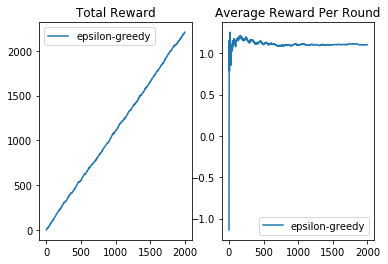

In [110]:
# Let's plot the sum and average reward over 2000 samples
plt.subplot(1, 2, 1)
plt.plot(sumreward_greedy_eps)
plt.title("Total Reward")
plt.legend(["epsilon-greedy"])

plt.subplot(1, 2, 2)
plt.plot(avereward_greedy_eps)
plt.title("Average Reward Per Round")
plt.legend(["epsilon-greedy"])
plt.show()

The result clearly shows that by taking standard deviations of each group into the epsilon greedy model, **most groups have sufficient samples and have very close and small standard deviation**. Hence, I believe the modified model does a good job. In addition, based on the two plots above, **the model is extremely cost-aware**. **After some rounds of exploration, model quickly finds the best group**.

In [111]:
# check out the values, counter, and standard deviations.
print('The current values of the four groups: {}, {}, {}, {}'.format(round(curr_values[0],3),round(curr_values[1],3),round(curr_values[2],3),round(curr_values[3],3)))
print('The standard deviation of the four groups: {}, {}, {}, {}'.format(round(std[0],3),round(std[1],3),round(std[2],3),round(std[3],3)))
print('The amount of samples in the four groups: {}, {}, {}, {}'.format(round(counter[0],0),round(counter[1],0),round(counter[2],0),round(counter[3],0)))

The current values of the four groups: 0.015, 1.423, 0.337, -0.784
The standard deviation of the four groups: 0.99, 1.014, 1.087, 1.035
The amount of samples in the four groups: 134, 1593, 136, 137


## Method2: Upper-Confidence-Bound (UCB) Strategy  + Minimize Group Standard Deviation 
In this modified method, I UCB strategy as the foundation. At the same time, I take standard deviation of each group into account. I try to **minimize the standard deviation of each group while being cost-aware at the same time**. 
  
$$A_t = \arg\max_a \left\{Q_t(a) + STD(a) + c \cdot \sqrt{\frac{\ln t}{N_t(a)}} \right\}$$
where $c$ is a constant that controls the "aggressiveness" of exploration, and $N_t(a)$ is the number of times that action $a$ has been taken in the previous $t-1$ rounds (i.e., the same as $\sum_{i=1}^{t-1} \mathbb{1}_{A_i = a}$).
  
Compare to the original formula, there's a new addition term **STD(a)**. It is the standard deviation of each group's past rewards. In order to make sure **the model explore more** at the begining stage, I **force the initial values of the standard deviation of those groups not chosen yet to be 1**. Hence, the first two elements of the formula for thoses groups not chosen yet would be large. Thus, they would be more likely to be chosen in the begining stage.

  


In [120]:
# C. Create a function to calculate the adjusted values under UCB
def ucb_calc(curr_values, t, counter, c):
    ucb_values = [0]*len(curr_values)
    for i in range(k):
        if counter[i] == 0:
            ucb_values[i] = curr_values[i] + 9999.99   # some very large number to represent "infinity"
        else:
            ucb_values[i] = curr_values[i] + c * np.sqrt(np.log(t) / counter[i])
    return ucb_values

In [136]:
np.random.seed(999)
# Create a 2D list to store all the rewards so that we could calculate the standard deviation
all_rewards=[]
for i in range(k):
    tem=[]
    all_rewards.append([])

# Create a list to store each group's standard deviation
# With a initial value of 1, it forces the machine to choose those groups with no samples in initial stage
std=[1]*k  

# Create a variable called final value = current value + standard deviation
final_values=[0]*k

# UCB
curr_values = [0]*k  # initial values
counter = [0]*k  # initialize counter
c = 10 #Lots of exploration
reward_ucb = []
sumreward_ucb = []
avereward_ucb = []
for t in range(T):
    # do the UCB value adjustments
    ucb_values = ucb_calc(curr_values, t+1, counter, c)
    final_values=np.add(std,ucb_values)
    # current best arm
    group = np.argmax(final_values)    
    reward = choose(group)
    reward_ucb.append(reward)
    
    all_rewards[group].append(reward) #store all the historic rewards for each group
    for i in range(k): #calculate standard deviation for each group
        if np.isnan(np.std(all_rewards[i])):
            std
        else:
            std[i]=np.std(all_rewards[i])
    
    # record sum and average reward up to this round
    sumreward_ucb.append(np.sum(reward_ucb))
    avereward_ucb.append(np.mean(reward_ucb))
    # update curr_values
    curr_values, counter = value_est(curr_values, counter, group, reward)
    #final_values=np.add(std,curr_values)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


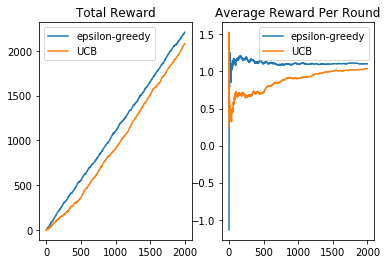

In [139]:
# Let's plot the sum and average reward over 2000 samples
plt.subplot(1, 2, 1)
plt.plot(sumreward_greedy_eps)
plt.plot(sumreward_ucb)
plt.title("Total Reward")
plt.legend(["epsilon-greedy","UCB"])

plt.subplot(1, 2, 2)
plt.plot(avereward_greedy_eps)
plt.plot(avereward_ucb)
plt.title("Average Reward Per Round")
plt.legend(["epsilon-greedy","UCB"])
plt.show()

The result clearly shows that by taking standard deviations of each group into the UCB model, **most groups have sufficient samples and have very close and small standard deviation**. Hence, I believe the modified model does a good job. In addition, based on the two plots above, **the model is cost-aware but not as good as the previous model**. **After some rounds of exploration, model quickly finds the best group**.

In [140]:
# check out the values, counter, and standard deviations.
print('The current values of the four groups: {}, {}, {}, {}'.format(round(curr_values[0],3),round(curr_values[1],3),round(curr_values[2],3),round(curr_values[3],3)))
print('The standard deviation of the four groups: {}, {}, {}, {}'.format(round(std[0],3),round(std[1],3),round(std[2],3),round(std[3],3)))
print('The amount of samples in the four groups: {}, {}, {}, {}'.format(round(counter[0],0),round(counter[1],0),round(counter[2],0),round(counter[3],0)))

The current values of the four groups: 0.173, 1.376, 0.339, -0.832
The standard deviation of the four groups: 1.039, 1.047, 0.991, 0.983
The amount of samples in the four groups: 204, 1478, 232, 86


## Conclusion:
By taking the standard deviation into account, **both modified methods do a great job at controling the standard deviation** and **force each group to acquire sufficent samples**. Furthermore, **the modified epsilon-greedy model is more cost-effective in general** and has both higher **total reward and average reward per round**.  
   
In conclusion, I believe that **taking the standard deviation of each group's past rewards into account** is a an effective way to **make cost-aware A/B testing model more robust** and make sure **all control and treatment groups have sufficient samples and small standard deviation**.